## **Dataset Link**

In [ ]:
# dataset link:https://www.kaggle.com/datasets/usmanafzaal/strawberry-disease-detection-dataset/code

## Mounting Google Drive in Google Colab



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Setting up YOLOv5 in Google Colab**

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch

import utils

display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-356-g2070b303 Python-3.10.12 torch-2.3.1+cu121 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.7/107.7 GB disk)


## Create Directory to unzip Dataset

In [ ]:
%cd /content
!mkdir Dataset

/content


## Directory Path

In [ ]:
import os

# Define paths
drive_path = '/content/drive/MyDrive/data'
zip_file_path = os.path.join(drive_path, 'strawberry_disease_dataset.zip')  # zip file name
extract_to_path = '/content/Dataset'  # Path where you want to unzip the files

In [ ]:
%cd /content

/content


In [ ]:
%pwd

'/content'

## Unzip Dataset in Dataset Directory

In [ ]:
# os.makedirs(extract_to_path, exist_ok=True)

# Unzip the file
!unzip -q "{zip_file_path}" -d "{extract_to_path}"

In [ ]:
%cd /content/Dataset

/content/Dataset


# **Parser **
This script processes a dataset of strawberry disease images, converting JSON annotations into YOLO format labels. It organizes the images and corresponding labels into separate folders and normalizes polygon coordinates for object detection. Adjust image dimensions and paths as needed before running.

In [ ]:
import os
import json
import shutil

# Define class mapping: map each disease label to a unique class ID
class_mapping = {
    "Angular Leafspot": 0,
    "Anthracnose Fruit Rot": 1,
    "Blossom Blight": 2,
    "Gray Mold": 3,
    "Leaf Spot": 4,
    "Powdery Mildew Fruit": 5,
    "Rust": 6,
}

def convert_to_yolo_format(json_file, output_file, image_width, image_height):
    with open(json_file, 'r') as f:
        data = json.load(f)

    with open(output_file, 'w') as f:
        for shape in data['shapes']:
            # Map class label to ID
            class_label = shape['label']
            class_id = class_mapping.get(class_label, -1)  # Default to -1 if label is not found

            if class_id == -1:
                print(f"Warning: {class_label} not found in class mapping. Skipping.")
                continue

            polygon = shape['points']

            # Flatten polygon points and normalize them
            normalized_polygon = []
            for point in polygon:
                x = point[0] / image_width
                y = point[1] / image_height
                normalized_polygon.append(x)
                normalized_polygon.append(y)

            # Optionally, compute bounding box (if needed)
            x_center = sum([p[0] for p in polygon]) / len(polygon) / image_width
            y_center = sum([p[1] for p in polygon]) / len(polygon) / image_height
            width = (max([p[0] for p in polygon]) - min([p[0] for p in polygon])) / image_width
            height = (max([p[1] for p in polygon]) - min([p[1] for p in polygon])) / image_height

            # Write to file in YOLO format
            f.write(f"{class_id} {x_center} {y_center} {width} {height} " + " ".join(map(str, normalized_polygon)) + "\n")

def process_folder(folder_path, image_width, image_height):
    images_dir = os.path.join(folder_path, 'images')
    labels_dir = os.path.join(folder_path, 'labels')

    # Create directories if they don't exist
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for file in os.listdir(folder_path):
        if file.endswith('.json'):
            json_file = os.path.join(folder_path, file)
            # Extract image file name from JSON
            with open(json_file, 'r') as f:
                data = json.load(f)
            image_file = os.path.join(folder_path, data['imagePath'])
            output_file = os.path.join(labels_dir, os.path.splitext(file)[0] + '.txt')

            if os.path.exists(image_file):
                # Move image to images folder
                shutil.move(image_file, os.path.join(images_dir, os.path.basename(image_file)))

                # Convert JSON to YOLO format and save in labels folder
                convert_to_yolo_format(json_file, output_file, image_width, image_height)

                # Optionally, move the JSON file as well (if you don't want to keep it in the original folder)
                # shutil.move(json_file, os.path.join(labels_dir, os.path.basename(json_file)))

# Example usage
dataset_dir = '/content/Dataset'  # Replace with the path to your dataset

# Assuming image dimensions are consistent, otherwise extract dynamically from JSON
image_width = 419  # Replace with actual image width
image_height = 419  # Replace with actual image height

folders = ['train', 'val', 'test']

for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    process_folder(folder_path, image_width, image_height)

# As I mentioned one class (Powdery Mildew Leaf) not found in train folder 

# **.Yaml file**
This code snippet creates a strawberry.yaml file containing paths to your training, validation, and test datasets, along with the class names for different strawberry diseases.

In [ ]:
# Define the YAML content with updated class names
%cd /content
yaml_content = """\
train: /content/Dataset/train/images
val: /content/Dataset/val/images
test: /content/Dataset/test/images
names:
  0: Angular Leafspot
  1: Anthracnose Fruit Rot
  2: Blossom Blight
  3: Gray Mold
  4: Leaf Spot
  5: Powdery Mildew Fruit
  6: Rust
"""

# Define the path to save the data.yaml file
data_yaml_path = '../content/yolov5/data/strawberry.yaml'

# Write the YAML content to the file
with open(data_yaml_path, 'w') as file:
    file.write(yaml_content)

# print(f"YAML file created at: {data_yaml_path}")


/content


# **Training**

In [ ]:
# %cd /content/yolov5
# !python segment/train.py --img 640 --batch 16 --epochs 100 --data strawberry.yaml --weights yolov5s-seg.pt --cache

/content/yolov5
2024-08-22 08:43:37.547672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 08:43:37.823394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 08:43:37.900161: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
segment/train: weights=yolov5s-seg.pt, cfg=, data=strawberry.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_

# **Load Your Saved Model(Trained on custom Dataset) **
As I have already trained and saved model on this Dataset, So I'm loading my saved model

In [ ]:
%cd /content/yolov5
import torch
model_path = '/content/drive/MyDrive/models/segmentation_model.pt'

# Load the model
torch.load(model_path)



/content/yolov5


{'epoch': -1,
 'best_fitness': None,
 'model': SegmentationModel(
   (model): Sequential(
     (0): Conv(
       (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
       (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (1): Conv(
       (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (2): C3(
       (cv1): Conv(
         (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU(inplace=True)
       )
       (cv2): Conv(
         (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, tra

# inference on the images
This command runs inference on a test image using a your trained segmentation model with specified weights and settings.

In [ ]:
!python segment/predict.py --weights /content/drive/MyDrive/models/segmentation_model.pt --img 640 --conf 0.25 --source /content/Dataset/test/images/gray_mold456.jpg

segment/predict: weights=['/content/drive/MyDrive/models/segmentation_model.pt'], source=/content/Dataset/test/images/gray_mold456.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v7.0-356-g2070b303 Python-3.10.12 torch-2.3.1+cu121 CPU

Fusing layers... 
Model summary: 165 layers, 7414604 parameters, 0 gradients, 25.7 GFLOPs
image 1/1 /content/Dataset/test/images/gray_mold456.jpg: 640x640 1 Gray Mold, 949.5ms
Speed: 4.9ms pre-process, 949.5ms inference, 1.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/predict-seg/exp4


# Output

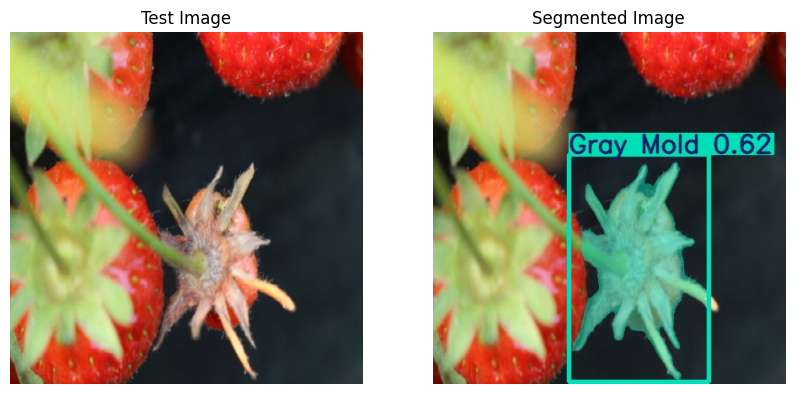

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load the test image
test_image_path = '/content/Dataset/test/images/gray_mold456.jpg'
test_image = cv2.imread(test_image_path)
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Load the segmented image (assuming it's saved after inference)
segmented_image_path = '/content/yolov5/runs/predict-seg/exp/gray_mold456.jpg'  # Update the path if needed
segmented_image = cv2.imread(segmented_image_path)
segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

# Display the images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(test_image_rgb)
plt.title('Test Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image_rgb)
plt.title('Segmented Image')
plt.axis('off')

plt.show()



# Save Your Trained Model

In [ ]:
# import os

# # Define the path to the folder
# save_folder = '/content/drive/MyDrive/models'

# # Create the folder if it doesn't exist
# os.makedirs(save_folder, exist_ok=True)

# # Define the full path to save the model
# save_path = os.path.join(save_folder, 'segmentation_model.pt')  # name

# import torch

# # Path where the trained model is saved by YOLOv5
# trained_model_path = '/content/yolov5/runs/train-seg/exp/weights/best.pt'


# # Save the entire model to the specified Google Drive path
# torch.save(torch.load(trained_model_path), save_path)


